In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tqdm import tqdm
import networkx as nx
import random

In [2]:
def sigmoid(x):
    return 1/(1+np.exp(-x))
def linear(x):
    return x
def softmax(x):
    expx = np.exp(x - np.max(x))
    return expx / expx.sum(axis=0, keepdims=True)

In [3]:
def uniform(size, prev_size):
    return np.random.uniform(size=size*prev_size)
def He(size, prev_size):
    return np.random.normal(scale=np.sqrt(2/prev_size),size=size*prev_size)
def Xavier(size, prev_size):
    return np.random.uniform(low=-1, high=1,size=size*prev_size)*np.sqrt(6)/(size+prev_size)

In [4]:
def sigmoid_grad(x):
    return sigmoid(x)*(1-sigmoid(x))
def linear_grad(x):
    return x/x
def softmax_grad(x):
    s = x.reshape(-1,1)
    return np.diagflat(s) - np.dot(s, s.T)

In [5]:
def MSE(y_true, y_pred):
    diff = y_pred.T - y_true
    mse = np.sum(diff**2) / diff.size
    return mse
def CE(y_true, y_pred):
    ce = -np.mean(y_true * np.log(y_pred.T + 1e-8))
    return ce

In [6]:
def MSE_grad(y_true, y_pred):
    mse_grad = (2/y_true.size) * (y_pred.T - y_true)
    return mse_grad
def CE_grad(y_true, y_pred):
    return y_pred - y_true

In [7]:
functions = {"sigmoid":sigmoid, "linear":linear, "softmax":softmax}
weights_methods_dict = {"uniform":uniform, "He":He, "Xavier":Xavier}
functions_grads = {"sigmoid":sigmoid_grad, "linear":linear_grad, "softmax":softmax_grad}
loss_dict = {"MSE":MSE, "CE":CE}
loss_grad_dict = {"MSE":MSE_grad, "CE":CE_grad}

In [8]:
class Layer:
    def __init__(self,size,prev_size,act_func="linear",weights_method="uniform"):
        self.size = size
        self.prev_size = prev_size
        self.value_before = None
        self.value_after = None
        self.biases = None
        self.weights = None
        self.act_func = functions[act_func]
        self.weights_method = weights_methods_dict[weights_method]
        self.grad = functions_grads[act_func]
        self._make_weights()
        self._make_biases()
        
    def _make_weights(self):
        W = self.weights_method(self.prev_size, self.size)
        W.resize(self.prev_size, self.size)
        self.weights = W
    
    def _make_biases(self):
        B = self.weights_method(self.size, 1)
        B = np.reshape(B, (1, self.size))
        self.biases = B
        
    def change_layer_biases(self,biases):
        biases = np.reshape(biases,(1,self.size))
        self.biases = biases
    
    def change_layer_weights(self,weights):
        weights = np.array(weights)
        weights.resize(self.prev_size, self.size)
        self.weights = weights
        
    def feedforward(self, a):
        self.value_before = np.dot(a,self.weights)+self.biases
        self.value_after = self.act_func(self.value_before)
        return self.value_after
    
    def layer_grad(self):
        return self.grad(self.value_before)

In [144]:
class MLP:
    def __init__(self,input_size,layers_size,act_functions,weights_methods):
        self.layers = []
        self.input_size = input_size
        self._make_layers(layers_size,act_functions, weights_methods)
        self.optimizer_dict = {"SGD":self.SGD, "GD":self.GD, "BGD":self.BGD, "Momentum":self.momentum, "RMSProp":self.RMSProp}
        self.optimizer = None
        self.loss = None
        self.loss_grad = None
        self.lr = None
        self.losses = []
        
        
    def _make_layers(self,layers_size, act_functions, weights_methods):
        layers_size.insert(0,self.input_size)
        for i in range(1,len(layers_size)):
            self.layers.append(Layer(layers_size[i], layers_size[i-1],act_functions[i-1],weights_methods[i-1]))
    
    def predict(self, x):
        for layer in self.layers:
            x = layer.feedforward(x)
        return x
      
    def backpropagation(self, X, Y):
        delta_w = [0 for _ in range(len(self.layers))]
        delta_b = [0 for _ in range(len(self.layers))]
        error_o = self.loss_grad(Y, self.layers[-1].value_after)
        for i in reversed(range(len(self.layers) - 1)):
            error_i = np.multiply(self.layers[i+1].weights.dot(error_o) ,self.layers[i].layer_grad().T)
            delta_w[i+1] = error_o.dot(self.layers[i].value_after)
            delta_b[i+1] = np.sum(error_o, axis=1, keepdims=True)
            error_o = error_i
        delta_w[0] = error_o.dot([X])
        delta_b[0] = np.sum(error_o, axis=1, keepdims=True)
        return delta_w, delta_b
    
    def update_params(self, delta_w, delta_b, lr):
        for i in range(len(self.layers)):
            layer = self.layers[i]
            layer.weights = layer.weights - lr * delta_w[i].T
            layer.biases = layer.biases - lr * delta_b[i].T

    def SGD(self, X, Y, epochs, batch_size, l, eta, beta):
        for i in range(epochs):
            y_hat = np.array([])
            for x,y in zip(X,Y):
                y_hat = np.append(y_hat, self.predict(x))
                dw, db = self.backpropagation(x,y)
                self.update_params(dw, db, self.lr)
            self.losses.append(self.loss(y_hat, Y))
            print(f"Epoch {i+1}/{epochs} - loss: {self.loss(Y, y_hat)}")
                
    def GD(self, X, Y, epochs, batch_size, l, beta):
        for i in range(epochs):
            dw_final = [0 for _ in range(len(self.layers))]
            db_final = [0 for _ in range(len(self.layers))]
            y_hat = np.array([])
            for x,y in zip(X,Y):
                y_hat = np.append(y_hat,self.predict(x))
                dw, db = self.backpropagation(x,y)
                dw_final = [dw_final[i] + self.lr * dw[i] for i in range(len(self.layers))]
                db_final = [db_final[i] + self.lr * db[i] for i in range(len(self.layers))]
            self.update_params(dw_final, db_final, 1)
            self.losses.append(self.loss(y_hat, Y))
            print(f"Epoch {i+1}/{epochs} - loss: {self.loss(y_hat, Y)}")
            
    def BGD(self, X, Y, epochs, batch_size, l, beta):
        for i in range(epochs):
            y_hat = np.array([])
            np.random.seed(1337)
            np.random.shuffle(X)
            np.random.seed(1337)
            np.random.shuffle(Y)
            batches_x = np.array_split(X, batch_size)
            batches_y = np.array_split(Y, batch_size)
            for batch_x, batch_y in zip(batches_x, batches_y):
                dw_final = [0 for _ in range(len(self.layers))]
                db_final = [0 for _ in range(len(self.layers))]
                for x, y in zip(batch_x, batch_y):
                    y_hat = np.append(y_hat,self.predict(x))
                    dw, db = self.backpropagation(x,y)
                    dw_final = [dw_final[i] + self.lr * dw[i] for i in range(len(self.layers))]
                    db_final = [db_final[i] + self.lr * db[i] for i in range(len(self.layers))]
                self.update_params(dw_final, db_final, 1) 
            self.losses.append(self.loss(y_hat, Y))
            print(f"Epoch {i+1}/{epochs} - loss: {self.loss(y_hat, Y)}")
        
    def momentum(self, X, Y, epochs, batch_size, l, beta):
        momentum_dw = [0 for _ in range(len(self.layers))]
        momentum_db = [0 for _ in range(len(self.layers))]
        for i in range(epochs):
            dw_final = [0 for _ in range(len(self.layers))]
            db_final = [0 for _ in range(len(self.layers))]
            y_hat = []
            for x,y in zip(X,Y):
                y_hat = np.append(y_hat,self.predict(x))
                dw, db = self.backpropagation(x,y)
                dw_final = [dw_final[i] + dw[i] for i in range(len(self.layers))]
                db_final = [db_final[i] + db[i] for i in range(len(self.layers))]
            momentum_dw = [dw_final[i] + momentum_dw[i] * l for i in range(len(self.layers))]
            momentum_db = [db_final[i] + momentum_db[i] * l for i in range(len(self.layers))]
            self.update_params(momentum_dw, momentum_db, self.lr)
            self.losses.append(mean_squared_error(self.scaler.inverse_transform(y_hat.reshape(-1, 1)), scaler.inverse_transform(Y.reshape(-1, 1))))
            print(f"Epoch {i+1}/{epochs} - loss: {mean_squared_error(self.scaler.inverse_transform(y_hat.reshape(-1, 1)), scaler.inverse_transform(Y.reshape(-1, 1)))}")
    
    def RMSProp(self, X, Y, epochs, batch_size, l, beta):
        exp_g_dw = [0 for _ in range(len(self.layers))]
        exp_g_db = [0 for _ in range(len(self.layers))]
        for i in range(epochs):
            g_dw_final = [0 for _ in range(len(self.layers))]
            g_db_final = [0 for _ in range(len(self.layers))]
            y_hat = []
            for x,y in zip(X,Y):
                y_hat = np.append(y_hat, self.predict(x))
                dw, db = self.backpropagation(x,y)
                g_dw_final = [g_dw_final[i] + dw[i] for i in range(len(self.layers))]
                g_db_final = [g_db_final[i] + db[i] for i in range(len(self.layers))]
            exp_g_dw = [exp_g_dw[i] * beta + (1-beta) * g_dw_final[i]**2 for i in range(len(self.layers))]
            exp_g_db = [exp_g_db[i] * beta + (1-beta) * g_db_final[i]**2 for i in range(len(self.layers))]
            g_dw_final = [g_dw_final[i]/(np.sqrt(exp_g_dw[i])+1e-8) for i in range(len(self.layers))]
            g_db_final = [g_db_final[i]/(np.sqrt(exp_g_db[i])+1e-8) for i in range(len(self.layers))]
            self.update_params(g_dw_final, g_db_final, self.lr)
            self.losses.append(self.loss(y_hat, Y))
            print(f"Epoch {i+1}/{epochs} - loss: {self.loss(y_hat, Y)}")
            
    def fit(self, X, Y, epochs=1000, batch_size=32, l=0.9, beta=0.9):
        scaler = StandardScaler()
        Y = scaler.fit_transform(Y)
        self.scaler = scaler
        self.optimizer(X, Y, epochs, batch_size, l, beta)
    
    def compile(self,loss,optimizer,lr):
        self.optimizer = self.optimizer_dict[optimizer]
        self.loss = loss_dict[loss]
        self.loss_grad = loss_grad_dict[loss]
        self.lr = lr
        
    def draw(self):
        sizes = [layer.size for layer in self.layers]
        sizes.insert(0,self.input_size)
        x = 0
        basey = 10
        step = 3
        G = nx.Graph()
        pos = {}
        edge_labels = {}
        edge_labels_final = {}
        for i in range(len(sizes)):
            for j in range(sizes[i]):
                G.add_node(str(i)+str(j))
                y = (j+1)/(sizes[i]+1) * basey
                pos[str(i)+str(j)] = np.array([x,y])
            x += step 
        for i in range(len(sizes)-1):
            for j in range(sizes[i]):
                for k in range(sizes[i+1]):
                    G.add_edge(str(i)+str(j),str(i+1)+str(k))
                    edge_labels[(str(i)+str(j),str(i+1)+str(k))] = str(round(self.layers[i].weights[j][k],3))
            if sizes[i] == 1 or sizes[i+1] == 1:
                keys = list(edge_labels.keys())
                random_keys = keys[::max(sizes[i],sizes[i+1])//10]
                edge_labels_final.update({k: edge_labels[k] for k in random_keys})
            edge_labels = {}
        fig = plt.figure(figsize=(80, 40))
        ax = fig.add_subplot(111)
        nx.draw(G, pos, with_labels=True, font_weight='bold',node_size=20000,width=10)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels_final,
                                     font_color='red',font_size=80)

# square-large (MSE: 1)

## Momentum

In [13]:
train_df = pd.read_csv("data/square-large-training.csv",index_col=0)
test_df = pd.read_csv("data/square-large-test.csv",index_col=0)

In [50]:
X_train = np.reshape(train_df["x"].values,(len(train_df),1))
Y_train = np.reshape(train_df["y"].values,(len(train_df),1))

In [51]:
X_test = np.reshape(test_df["x"].values,(len(test_df),1))
Y_test = np.reshape(test_df["y"].values,(len(test_df),1))

In [52]:
nn = MLP(1,[100,1],["sigmoid","linear"],["uniform","uniform"])
nn.compile(loss = "MSE",optimizer = "Momentum", lr = 0.00003)

In [53]:
nn.fit(X_train, Y_train, epochs = 2000, l=0.9)

Epoch 1/2000 - loss: 12497.749511269934
Epoch 2/2000 - loss: 15524.43587466774
Epoch 3/2000 - loss: 8677.732777653295
Epoch 4/2000 - loss: 9416.83648387692
Epoch 5/2000 - loss: 9501.348118035365
Epoch 6/2000 - loss: 9280.960193220786
Epoch 7/2000 - loss: 8895.50482396447
Epoch 8/2000 - loss: 8321.667893505984
Epoch 9/2000 - loss: 7559.490693638768
Epoch 10/2000 - loss: 6624.824921979665
Epoch 11/2000 - loss: 5877.734958407992
Epoch 12/2000 - loss: 5599.705414111033
Epoch 13/2000 - loss: 5528.601857400436
Epoch 14/2000 - loss: 5541.354764687943
Epoch 15/2000 - loss: 5390.492723442857
Epoch 16/2000 - loss: 5016.346223392517
Epoch 17/2000 - loss: 4478.528484803415
Epoch 18/2000 - loss: 3977.309202336586
Epoch 19/2000 - loss: 3587.984512291031
Epoch 20/2000 - loss: 3259.662012582623
Epoch 21/2000 - loss: 2960.659364197528
Epoch 22/2000 - loss: 2652.4422291958304
Epoch 23/2000 - loss: 2294.877690857799
Epoch 24/2000 - loss: 1931.7409655261501
Epoch 25/2000 - loss: 1662.662273231461
Epoch 26

Epoch 202/2000 - loss: 7.460853226013309
Epoch 203/2000 - loss: 7.406071994265114
Epoch 204/2000 - loss: 7.351868850432149
Epoch 205/2000 - loss: 7.298238020501013
Epoch 206/2000 - loss: 7.245172259441327
Epoch 207/2000 - loss: 7.19266147144194
Epoch 208/2000 - loss: 7.140700806545557
Epoch 209/2000 - loss: 7.089282298998809
Epoch 210/2000 - loss: 7.038399517589905
Epoch 211/2000 - loss: 6.988044674495924
Epoch 212/2000 - loss: 6.938210916742736
Epoch 213/2000 - loss: 6.8888925097253555
Epoch 214/2000 - loss: 6.840081783412655
Epoch 215/2000 - loss: 6.791773064752722
Epoch 216/2000 - loss: 6.7439594249192565
Epoch 217/2000 - loss: 6.6966346528340654
Epoch 218/2000 - loss: 6.649793349788704
Epoch 219/2000 - loss: 6.60342848770637
Epoch 220/2000 - loss: 6.557534365039446
Epoch 221/2000 - loss: 6.512105338010597
Epoch 222/2000 - loss: 6.46713541927562
Epoch 223/2000 - loss: 6.422619143997185
Epoch 224/2000 - loss: 6.378550693848758
Epoch 225/2000 - loss: 6.334924537811004
Epoch 226/2000 -

Epoch 402/2000 - loss: 2.526512139895559
Epoch 403/2000 - loss: 2.5169609055322515
Epoch 404/2000 - loss: 2.507477960164392
Epoch 405/2000 - loss: 2.498062674160571
Epoch 406/2000 - loss: 2.4887144241697032
Epoch 407/2000 - loss: 2.479432593046723
Epoch 408/2000 - loss: 2.470216569779075
Epoch 409/2000 - loss: 2.4610657494149044
Epoch 410/2000 - loss: 2.451979532991727
Epoch 411/2000 - loss: 2.442957327465568
Epoch 412/2000 - loss: 2.4339985456417743
Epoch 413/2000 - loss: 2.425102606106441
Epoch 414/2000 - loss: 2.416268933158394
Epoch 415/2000 - loss: 2.4074969567426696
Epoch 416/2000 - loss: 2.3987861123843914
Epoch 417/2000 - loss: 2.3901358411234623
Epoch 418/2000 - loss: 2.3815455894506172
Epoch 419/2000 - loss: 2.373014809244081
Epoch 420/2000 - loss: 2.364542957706784
Epoch 421/2000 - loss: 2.3561294973047144
Epoch 422/2000 - loss: 2.347773895705858
Epoch 423/2000 - loss: 2.3394756257198837
Epoch 424/2000 - loss: 2.331234165238996
Epoch 425/2000 - loss: 2.323048997179334
Epoch 

Epoch 599/2000 - loss: 1.4347103256984306
Epoch 600/2000 - loss: 1.431418086980384
Epoch 601/2000 - loss: 1.4281369523783243
Epoch 602/2000 - loss: 1.4248668216798839
Epoch 603/2000 - loss: 1.4216075958717378
Epoch 604/2000 - loss: 1.4183591771367308
Epoch 605/2000 - loss: 1.4151214688510378
Epoch 606/2000 - loss: 1.411894375581414
Epoch 607/2000 - loss: 1.4086778030824711
Epoch 608/2000 - loss: 1.405471658294029
Epoch 609/2000 - loss: 1.4022758493384797
Epoch 610/2000 - loss: 1.399090285518224
Epoch 611/2000 - loss: 1.3959148773131347
Epoch 612/2000 - loss: 1.3927495363780031
Epoch 613/2000 - loss: 1.3895941755401153
Epoch 614/2000 - loss: 1.3864487087967148
Epoch 615/2000 - loss: 1.383313051312602
Epoch 616/2000 - loss: 1.3801871194176463
Epoch 617/2000 - loss: 1.3770708306043944
Epoch 618/2000 - loss: 1.373964103525581
Epoch 619/2000 - loss: 1.3708668579917072
Epoch 620/2000 - loss: 1.367779014968577
Epoch 621/2000 - loss: 1.3647004965748113
Epoch 622/2000 - loss: 1.3616312260793568

Epoch 796/2000 - loss: 0.9357863903421301
Epoch 797/2000 - loss: 0.9338886182066081
Epoch 798/2000 - loss: 0.931996506626195
Epoch 799/2000 - loss: 0.930110038070851
Epoch 800/2000 - loss: 0.928229194947789
Epoch 801/2000 - loss: 0.9263539596112611
Epoch 802/2000 - loss: 0.9244843143723677
Epoch 803/2000 - loss: 0.9226202415087725
Epoch 804/2000 - loss: 0.9207617232743665
Epoch 805/2000 - loss: 0.918908741908864
Epoch 806/2000 - loss: 0.9170612796472888
Epoch 807/2000 - loss: 0.9152193187293604
Epoch 808/2000 - loss: 0.9133828414087788
Epoch 809/2000 - loss: 0.9115518299623577
Epoch 810/2000 - loss: 0.9097262666990572
Epoch 811/2000 - loss: 0.9079061339688174
Epoch 812/2000 - loss: 0.9060914141712728
Epoch 813/2000 - loss: 0.90428208976428
Epoch 814/2000 - loss: 0.9024781432722575
Epoch 815/2000 - loss: 0.9006795572943374
Epoch 816/2000 - loss: 0.8988863145123421
Epoch 817/2000 - loss: 0.897098397698501
Epoch 818/2000 - loss: 0.8953157897230074
Epoch 819/2000 - loss: 0.8935384735612907

Epoch 993/2000 - loss: 0.6544119018346506
Epoch 994/2000 - loss: 0.6533855860858635
Epoch 995/2000 - loss: 0.652362486785704
Epoch 996/2000 - loss: 0.6513425893865089
Epoch 997/2000 - loss: 0.6503258793762144
Epoch 998/2000 - loss: 0.6493123422800331
Epoch 999/2000 - loss: 0.6483019636620472
Epoch 1000/2000 - loss: 0.6472947291267759
Epoch 1001/2000 - loss: 0.6462906243206747
Epoch 1002/2000 - loss: 0.6452896349335843
Epoch 1003/2000 - loss: 0.6442917467001489
Epoch 1004/2000 - loss: 0.6432969454011428
Epoch 1005/2000 - loss: 0.6423052168647887
Epoch 1006/2000 - loss: 0.6413165469680084
Epoch 1007/2000 - loss: 0.6403309216376094
Epoch 1008/2000 - loss: 0.6393483268514559
Epoch 1009/2000 - loss: 0.6383687486395728
Epoch 1010/2000 - loss: 0.6373921730851985
Epoch 1011/2000 - loss: 0.6364185863257983
Epoch 1012/2000 - loss: 0.6354479745540439
Epoch 1013/2000 - loss: 0.6344803240187217
Epoch 1014/2000 - loss: 0.6335156210256198
Epoch 1015/2000 - loss: 0.6325538519383846
Epoch 1016/2000 - l

Epoch 1185/2000 - loss: 0.5025871471513482
Epoch 1186/2000 - loss: 0.501978166845473
Epoch 1187/2000 - loss: 0.501370631071978
Epoch 1188/2000 - loss: 0.5007645348463449
Epoch 1189/2000 - loss: 0.5001598732114052
Epoch 1190/2000 - loss: 0.49955664123714305
Epoch 1191/2000 - loss: 0.4989548340205118
Epoch 1192/2000 - loss: 0.4983544466852384
Epoch 1193/2000 - loss: 0.49775547438164425
Epoch 1194/2000 - loss: 0.4971579122864549
Epoch 1195/2000 - loss: 0.4965617556026035
Epoch 1196/2000 - loss: 0.49596699955907336
Epoch 1197/2000 - loss: 0.49537363941069557
Epoch 1198/2000 - loss: 0.49478167043798355
Epoch 1199/2000 - loss: 0.49419108794693195
Epoch 1200/2000 - loss: 0.4936018872688652
Epoch 1201/2000 - loss: 0.49301406376024803
Epoch 1202/2000 - loss: 0.4924276128025053
Epoch 1203/2000 - loss: 0.49184252980186094
Epoch 1204/2000 - loss: 0.4912588101891638
Epoch 1205/2000 - loss: 0.490676449419707
Epoch 1206/2000 - loss: 0.4900954429730662
Epoch 1207/2000 - loss: 0.48951578635293563
Epoch

Epoch 1376/2000 - loss: 0.4079430468753666
Epoch 1377/2000 - loss: 0.4075427936003702
Epoch 1378/2000 - loss: 0.4071433685723848
Epoch 1379/2000 - loss: 0.4067447697158761
Epoch 1380/2000 - loss: 0.40634699496256027
Epoch 1381/2000 - loss: 0.4059500422513512
Epoch 1382/2000 - loss: 0.4055539095283254
Epoch 1383/2000 - loss: 0.4051585947466576
Epoch 1384/2000 - loss: 0.4047640958665754
Epoch 1385/2000 - loss: 0.4043704108553122
Epoch 1386/2000 - loss: 0.40397753768705325
Epoch 1387/2000 - loss: 0.4035854743428878
Epoch 1388/2000 - loss: 0.40319421881075984
Epoch 1389/2000 - loss: 0.4028037690854264
Epoch 1390/2000 - loss: 0.402414123168401
Epoch 1391/2000 - loss: 0.40202527906790925
Epoch 1392/2000 - loss: 0.40163723479884106
Epoch 1393/2000 - loss: 0.40124998838271136
Epoch 1394/2000 - loss: 0.4008635378476005
Epoch 1395/2000 - loss: 0.4004778812281158
Epoch 1396/2000 - loss: 0.40009301656534524
Epoch 1397/2000 - loss: 0.39970894190681283
Epoch 1398/2000 - loss: 0.39932565530642805
Epo

Epoch 1566/2000 - loss: 0.34473235674729097
Epoch 1567/2000 - loss: 0.3444583152466766
Epoch 1568/2000 - loss: 0.3441847970455683
Epoch 1569/2000 - loss: 0.34391180087036644
Epoch 1570/2000 - loss: 0.3436393254500519
Epoch 1571/2000 - loss: 0.34336736951618535
Epoch 1572/2000 - loss: 0.34309593180290293
Epoch 1573/2000 - loss: 0.342825011046903
Epoch 1574/2000 - loss: 0.3425546059874482
Epoch 1575/2000 - loss: 0.3422847153663467
Epoch 1576/2000 - loss: 0.3420153379279633
Epoch 1577/2000 - loss: 0.34174647241920036
Epoch 1578/2000 - loss: 0.34147811758949764
Epoch 1579/2000 - loss: 0.3412102721908254
Epoch 1580/2000 - loss: 0.34094293497768086
Epoch 1581/2000 - loss: 0.34067610470707577
Epoch 1582/2000 - loss: 0.34040978013854556
Epoch 1583/2000 - loss: 0.34014396003412206
Epoch 1584/2000 - loss: 0.33987864315835714
Epoch 1585/2000 - loss: 0.3396138282782824
Epoch 1586/2000 - loss: 0.339349514163438
Epoch 1587/2000 - loss: 0.33908569958585266
Epoch 1588/2000 - loss: 0.3388223833200267
E

Epoch 1757/2000 - loss: 0.3005602338655948
Epoch 1758/2000 - loss: 0.30036577775829687
Epoch 1759/2000 - loss: 0.3001716445447987
Epoch 1760/2000 - loss: 0.29997783338946393
Epoch 1761/2000 - loss: 0.2997843434587668
Epoch 1762/2000 - loss: 0.29959117392128554
Epoch 1763/2000 - loss: 0.2993983239477036
Epoch 1764/2000 - loss: 0.29920579271080067
Epoch 1765/2000 - loss: 0.2990135793854623
Epoch 1766/2000 - loss: 0.29882168314866625
Epoch 1767/2000 - loss: 0.2986301031794842
Epoch 1768/2000 - loss: 0.2984388386590783
Epoch 1769/2000 - loss: 0.29824788877070607
Epoch 1770/2000 - loss: 0.29805725269970923
Epoch 1771/2000 - loss: 0.29786692963350914
Epoch 1772/2000 - loss: 0.2976769187616205
Epoch 1773/2000 - loss: 0.29748721927562355
Epoch 1774/2000 - loss: 0.2972978303691895
Epoch 1775/2000 - loss: 0.2971087512380628
Epoch 1776/2000 - loss: 0.29691998108005113
Epoch 1777/2000 - loss: 0.2967315190950428
Epoch 1778/2000 - loss: 0.29654336448499163
Epoch 1779/2000 - loss: 0.2963555164539123


Epoch 1946/2000 - loss: 0.26872261075965725
Epoch 1947/2000 - loss: 0.2685765278337576
Epoch 1948/2000 - loss: 0.2684306441281339
Epoch 1949/2000 - loss: 0.2682849591512698
Epoch 1950/2000 - loss: 0.2681394724131336
Epoch 1951/2000 - loss: 0.2679941834251514
Epoch 1952/2000 - loss: 0.26784909170023297
Epoch 1953/2000 - loss: 0.2677041967527403
Epoch 1954/2000 - loss: 0.26755949809849594
Epoch 1955/2000 - loss: 0.26741499525478934
Epoch 1956/2000 - loss: 0.26727068774034884
Epoch 1957/2000 - loss: 0.26712657507536364
Epoch 1958/2000 - loss: 0.26698265678145167
Epoch 1959/2000 - loss: 0.26683893238169004
Epoch 1960/2000 - loss: 0.26669540140058007
Epoch 1961/2000 - loss: 0.26655206336405485
Epoch 1962/2000 - loss: 0.2664089177994863
Epoch 1963/2000 - loss: 0.26626596423566634
Epoch 1964/2000 - loss: 0.2661232022028075
Epoch 1965/2000 - loss: 0.26598063123253385
Epoch 1966/2000 - loss: 0.2658382508578952
Epoch 1967/2000 - loss: 0.26569606061334744
Epoch 1968/2000 - loss: 0.265554060034742

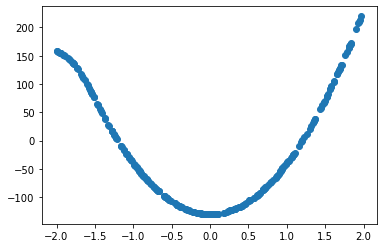

In [54]:
lossesMomentum = nn.losses
y_pred = nn.predict(X_test)
plt.scatter(X_test, y_pred)
plt.show()

In [55]:
#Duże MSE bo x w przedziale -1.5 do 2 na treningowym, a w testowym na przedziale -2 do 2
MSE(y_pred, Y_test)

19923.108071795712

-1.4985823482275


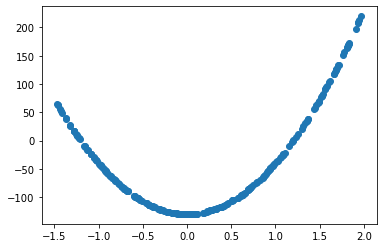

In [56]:
#Usuwanie ze zbioru testowego obserwacji z x<-1.5
test_df_mod = test_df.loc[test_df["x"]>min(train_df["x"].values)]
print(min(train_df["x"].values))
X_test_mod = np.reshape(test_df_mod["x"].values,(len(test_df_mod),1))
Y_test_mod = np.reshape(test_df_mod["y"].values,(len(test_df_mod),1))
y_pred_mod = nn.predict(X_test_mod)
plt.scatter(X_test_mod, y_pred_mod)
plt.show()

In [57]:
MSE(y_pred_mod, Y_test_mod)

14877.686009904928

## RMSProp

In [58]:
nn = MLP(1,[100,1],["sigmoid","linear"],["uniform","uniform"])
nn.compile(loss = "MSE",optimizer = "RMSProp", lr = 0.02)

In [59]:
nn.fit(X_train, Y_train, epochs = 2000, beta=0.9)

Epoch 1/2000 - loss: 12179.480688829966
Epoch 2/2000 - loss: 11655.291683090072
Epoch 3/2000 - loss: 11336.775081456934
Epoch 4/2000 - loss: 11099.150765748958
Epoch 5/2000 - loss: 10906.499520596919
Epoch 6/2000 - loss: 10743.08366213314
Epoch 7/2000 - loss: 10600.471917608496
Epoch 8/2000 - loss: 10473.529882325176
Epoch 9/2000 - loss: 10358.856027112957
Epoch 10/2000 - loss: 10254.066012205143
Epoch 11/2000 - loss: 10157.417901182604
Epoch 12/2000 - loss: 10067.594772703813
Epoch 13/2000 - loss: 9983.571737584822
Epoch 14/2000 - loss: 9904.533558387335
Epoch 15/2000 - loss: 9829.822383910463
Epoch 16/2000 - loss: 9758.901911704485
Epoch 17/2000 - loss: 9691.33041715096
Epoch 18/2000 - loss: 9626.73963176349
Epoch 19/2000 - loss: 9564.818323041729
Epoch 20/2000 - loss: 9505.299640061114
Epoch 21/2000 - loss: 9447.951249961958
Epoch 22/2000 - loss: 9392.567476571467
Epoch 23/2000 - loss: 9338.962968297954
Epoch 24/2000 - loss: 9286.967686276748
Epoch 25/2000 - loss: 9236.42308231476
E

Epoch 205/2000 - loss: 2797.0405446424547
Epoch 206/2000 - loss: 2777.475637165932
Epoch 207/2000 - loss: 2757.9941371162527
Epoch 208/2000 - loss: 2738.572301862861
Epoch 209/2000 - loss: 2719.224680027688
Epoch 210/2000 - loss: 2699.9226600322545
Epoch 211/2000 - loss: 2680.6782094337923
Epoch 212/2000 - loss: 2661.4604816892856
Epoch 213/2000 - loss: 2642.2892245639664
Epoch 214/2000 - loss: 2623.1369966123134
Epoch 215/2000 - loss: 2604.034204085857
Epoch 216/2000 - loss: 2584.956319848933
Epoch 217/2000 - loss: 2565.9380347392353
Epoch 218/2000 - loss: 2546.9546489833865
Epoch 219/2000 - loss: 2528.0406234539764
Epoch 220/2000 - loss: 2509.1688818304733
Epoch 221/2000 - loss: 2490.372938319475
Epoch 222/2000 - loss: 2471.6219356891434
Epoch 223/2000 - loss: 2452.949099576201
Epoch 224/2000 - loss: 2434.318772631676
Epoch 225/2000 - loss: 2415.7643868813757
Epoch 226/2000 - loss: 2397.2449263514354
Epoch 227/2000 - loss: 2378.7953467246207
Epoch 228/2000 - loss: 2360.3707439804557


Epoch 404/2000 - loss: 329.0690694163995
Epoch 405/2000 - loss: 323.4474339100187
Epoch 406/2000 - loss: 317.9318036781535
Epoch 407/2000 - loss: 312.45536831126793
Epoch 408/2000 - loss: 307.08176726955384
Epoch 409/2000 - loss: 301.7482711673798
Epoch 410/2000 - loss: 296.51452973886285
Epoch 411/2000 - loss: 291.3217262033237
Epoch 412/2000 - loss: 286.2256891298814
Epoch 413/2000 - loss: 281.1713613899637
Epoch 414/2000 - loss: 276.2109034404432
Epoch 415/2000 - loss: 271.2928684528417
Epoch 416/2000 - loss: 266.46589160845974
Epoch 417/2000 - loss: 261.68198605696347
Epoch 418/2000 - loss: 256.9864010107452
Epoch 419/2000 - loss: 252.33446044743184
Epoch 420/2000 - loss: 247.7681680681395
Epoch 421/2000 - loss: 243.24601513927908
Epoch 422/2000 - loss: 238.8069016064413
Epoch 423/2000 - loss: 234.41235053193782
Epoch 424/2000 - loss: 230.0982973507523
Epoch 425/2000 - loss: 225.82916849599184
Epoch 426/2000 - loss: 221.63806723484313
Epoch 427/2000 - loss: 217.49219912966345
Epoch

Epoch 604/2000 - loss: 13.610225934451504
Epoch 605/2000 - loss: 13.526571076325595
Epoch 606/2000 - loss: 13.458913223467247
Epoch 607/2000 - loss: 13.377754041796397
Epoch 608/2000 - loss: 13.312165704658486
Epoch 609/2000 - loss: 13.233382911141874
Epoch 610/2000 - loss: 13.169762575217595
Epoch 611/2000 - loss: 13.093244440420822
Epoch 612/2000 - loss: 13.031496975779824
Epoch 613/2000 - loss: 12.957138774235984
Epoch 614/2000 - loss: 12.897174950401375
Epoch 615/2000 - loss: 12.824878448327148
Epoch 616/2000 - loss: 12.766614491464
Epoch 617/2000 - loss: 12.696287473675442
Epoch 618/2000 - loss: 12.639644661561928
Epoch 619/2000 - loss: 12.57120049439708
Epoch 620/2000 - loss: 12.516104785380845
Epoch 621/2000 - loss: 12.449462013061757
Epoch 622/2000 - loss: 12.395843706064268
Epoch 623/2000 - loss: 12.330925678468681
Epoch 624/2000 - loss: 12.278719101644626
Epoch 625/2000 - loss: 12.215453631594064
Epoch 626/2000 - loss: 12.16459685734472
Epoch 627/2000 - loss: 12.1029159053015

Epoch 803/2000 - loss: 7.152950336704398
Epoch 804/2000 - loss: 7.135878582777172
Epoch 805/2000 - loss: 7.119904636392684
Epoch 806/2000 - loss: 7.102888669461854
Epoch 807/2000 - loss: 7.087061164578201
Epoch 808/2000 - loss: 7.070100435489756
Epoch 809/2000 - loss: 7.054418562349749
Epoch 810/2000 - loss: 7.037512688672554
Epoch 811/2000 - loss: 7.021975823245259
Epoch 812/2000 - loss: 7.0051245834149185
Epoch 813/2000 - loss: 6.9897322805485835
Epoch 814/2000 - loss: 6.9729356072829525
Epoch 815/2000 - loss: 6.957687593040833
Epoch 816/2000 - loss: 6.940945566053041
Epoch 817/2000 - loss: 6.925841729265006
Epoch 818/2000 - loss: 6.909154567309497
Epoch 819/2000 - loss: 6.894194950383584
Epoch 820/2000 - loss: 6.877563002681236
Epoch 821/2000 - loss: 6.862747791730791
Epoch 822/2000 - loss: 6.846171528827882
Epoch 823/2000 - loss: 6.831501043179863
Epoch 824/2000 - loss: 6.8149810473047925
Epoch 825/2000 - loss: 6.800455728464589
Epoch 826/2000 - loss: 6.783992683452816
Epoch 827/20

Epoch 1003/2000 - loss: 4.913624425239475
Epoch 1004/2000 - loss: 4.902643741598744
Epoch 1005/2000 - loss: 4.900805094543
Epoch 1006/2000 - loss: 4.889856402497094
Epoch 1007/2000 - loss: 4.888117768858072
Epoch 1008/2000 - loss: 4.877200371949626
Epoch 1009/2000 - loss: 4.875560826401508
Epoch 1010/2000 - loss: 4.864674036953215
Epoch 1011/2000 - loss: 4.863132663875456
Epoch 1012/2000 - loss: 4.852275802900426
Epoch 1013/2000 - loss: 4.850831696285967
Epoch 1014/2000 - loss: 4.840004093396368
Epoch 1015/2000 - loss: 4.838656356759046
Epoch 1016/2000 - loss: 4.827857350073735
Epoch 1017/2000 - loss: 4.8266050963552845
Epoch 1018/2000 - loss: 4.815834032406794
Epoch 1019/2000 - loss: 4.81467638388399
Epoch 1020/2000 - loss: 4.80393261752523
Epoch 1021/2000 - loss: 4.802868705717341
Epoch 1022/2000 - loss: 4.792151600028583
Epoch 1023/2000 - loss: 4.791180565605393
Epoch 1024/2000 - loss: 4.780489491801332
Epoch 1025/2000 - loss: 4.779610484491994
Epoch 1026/2000 - loss: 4.768944821829

Epoch 1200/2000 - loss: 4.083879635184541
Epoch 1201/2000 - loss: 4.088642940930239
Epoch 1202/2000 - loss: 4.07853591283389
Epoch 1203/2000 - loss: 4.083343526216449
Epoch 1204/2000 - loss: 4.07323057376919
Epoch 1205/2000 - loss: 4.078082194134215
Epoch 1206/2000 - loss: 4.067963159283807
Epoch 1207/2000 - loss: 4.072858489627302
Epoch 1208/2000 - loss: 4.062733217195488
Epoch 1209/2000 - loss: 4.06767196411757
Epoch 1210/2000 - loss: 4.0575403017592375
Epoch 1211/2000 - loss: 4.062522175418275
Epoch 1212/2000 - loss: 4.0523839735809695
Epoch 1213/2000 - loss: 4.057408687648053
Epoch 1214/2000 - loss: 4.047263799531909
Epoch 1215/2000 - loss: 4.052331071145667
Epoch 1216/2000 - loss: 4.042179352663657
Epoch 1217/2000 - loss: 4.047288902385627
Epoch 1218/2000 - loss: 4.037130212124184
Epoch 1219/2000 - loss: 4.042281763894358
Epoch 1220/2000 - loss: 4.032115963074397
Epoch 1221/2000 - loss: 4.0373092441672895
Epoch 1222/2000 - loss: 4.027136196605592
Epoch 1223/2000 - loss: 4.03237093

Epoch 1394/2000 - loss: 3.694382942631642
Epoch 1395/2000 - loss: 3.7024480225522858
Epoch 1396/2000 - loss: 3.691337025478154
Epoch 1397/2000 - loss: 3.6994288095192203
Epoch 1398/2000 - loss: 3.688305216136998
Epoch 1399/2000 - loss: 3.696423600509496
Epoch 1400/2000 - loss: 3.685287395743959
Epoch 1401/2000 - loss: 3.6934322775964947
Epoch 1402/2000 - loss: 3.6822834469331243
Epoch 1403/2000 - loss: 3.690454724338956
Epoch 1404/2000 - loss: 3.679293253813722
Epoch 1405/2000 - loss: 3.687490825757919
Epoch 1406/2000 - loss: 3.676316701947221
Epoch 1407/2000 - loss: 3.6845404683142635
Epoch 1408/2000 - loss: 3.673353678325152
Epoch 1409/2000 - loss: 3.681603539886592
Epoch 1410/2000 - loss: 3.670404071347107
Epoch 1411/2000 - loss: 3.6786799297493182
Epoch 1412/2000 - loss: 3.667467770798969
Epoch 1413/2000 - loss: 3.6757695285513137
Epoch 1414/2000 - loss: 3.6645446678317923
Epoch 1415/2000 - loss: 3.6728722282948083
Epoch 1416/2000 - loss: 3.6616346549408045
Epoch 1417/2000 - loss: 

Epoch 1588/2000 - loss: 3.45110071689036
Epoch 1589/2000 - loss: 3.4613767191006697
Epoch 1590/2000 - loss: 3.4490301724842047
Epoch 1591/2000 - loss: 3.4593258063997054
Epoch 1592/2000 - loss: 3.4469667768525953
Epoch 1593/2000 - loss: 3.457281990770216
Epoch 1594/2000 - loss: 3.4449104886826456
Epoch 1595/2000 - loss: 3.4552452311858266
Epoch 1596/2000 - loss: 3.4428612670393703
Epoch 1597/2000 - loss: 3.453215486995054
Epoch 1598/2000 - loss: 3.440819071360821
Epoch 1599/2000 - loss: 3.4511927179165096
Epoch 1600/2000 - loss: 3.4387838614535315
Epoch 1601/2000 - loss: 3.449176884034536
Epoch 1602/2000 - loss: 3.4367555974880193
Epoch 1603/2000 - loss: 3.4471679457945577
Epoch 1604/2000 - loss: 3.4347342399942327
Epoch 1605/2000 - loss: 3.445165863998712
Epoch 1606/2000 - loss: 3.432719749857214
Epoch 1607/2000 - loss: 3.4431705998014666
Epoch 1608/2000 - loss: 3.4307120883127706
Epoch 1609/2000 - loss: 3.441182114705363
Epoch 1610/2000 - loss: 3.4287112169431113
Epoch 1611/2000 - lo

Epoch 1782/2000 - loss: 3.2785167957595274
Epoch 1783/2000 - loss: 3.2904905536654523
Epoch 1784/2000 - loss: 3.276990475077334
Epoch 1785/2000 - loss: 3.2889798609333956
Epoch 1786/2000 - loss: 3.2754685527811116
Epoch 1787/2000 - loss: 3.2874735334159437
Epoch 1788/2000 - loss: 3.273951009891913
Epoch 1789/2000 - loss: 3.2859715522613886
Epoch 1790/2000 - loss: 3.2724378275659975
Epoch 1791/2000 - loss: 3.2844738987523834
Epoch 1792/2000 - loss: 3.2709289870936233
Epoch 1793/2000 - loss: 3.2829805543047876
Epoch 1794/2000 - loss: 3.2694244698979174
Epoch 1795/2000 - loss: 3.281491500466444
Epoch 1796/2000 - loss: 3.2679242575336733
Epoch 1797/2000 - loss: 3.2800067189162116
Epoch 1798/2000 - loss: 3.266428331686346
Epoch 1799/2000 - loss: 3.2785261914626727
Epoch 1800/2000 - loss: 3.2649366741707557
Epoch 1801/2000 - loss: 3.277049900043028
Epoch 1802/2000 - loss: 3.26344926693006
Epoch 1803/2000 - loss: 3.2755778267221105
Epoch 1804/2000 - loss: 3.261966092034742
Epoch 1805/2000 - l

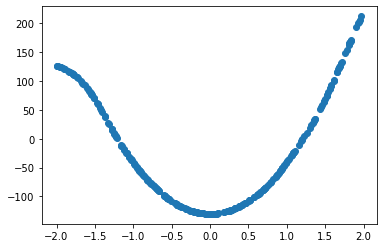

In [60]:
lossesRMSProp = nn.losses
y_pred = nn.predict(X_test)
plt.scatter(X_test, y_pred)
plt.show()

In [61]:
MSE(y_pred, Y_test)

19185.079240829542

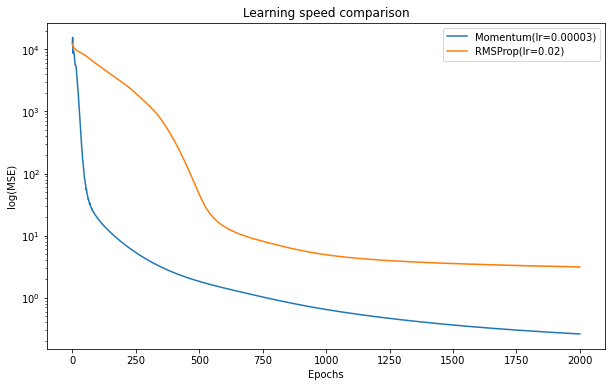

In [62]:
plt.figure(figsize=(10,6))
plt.plot(lossesMomentum,label="Momentum(lr=0.00003)")
plt.plot(lossesRMSProp,label="RMSProp(lr=0.02)")
plt.title('Learning speed comparison')
plt.xlabel('Epochs')
plt.ylabel('log(MSE)')
plt.yscale("log")
plt.legend()
plt.show()

# steps-large (MSE: 3)

## Momentum

In [12]:
train_df = pd.read_csv("data/steps-large-training.csv",index_col=0)
test_df = pd.read_csv("data/steps-large-test.csv",index_col=0)

In [ ]:
X_train = np.reshape(train_df["x"].values,(len(train_df),1))
Y_train = np.reshape(train_df["y"].values,(len(train_df),1))

In [ ]:
X_test = np.reshape(test_df["x"].values,(len(test_df),1))
Y_test = np.reshape(test_df["y"].values,(len(test_df),1))

In [38]:
nn = MLP(1,[40,1],["sigmoid","linear"],["Xavier","Xavier"])
nn.compile(loss = "MSE",optimizer = "Momentum", lr = 0.00001)

In [39]:
nn.fit(X_train, Y_train, epochs = 1000, l=0.9)

Epoch 1/1000 - loss: 7343.598328958919
Epoch 2/1000 - loss: 7488.767784321503
Epoch 3/1000 - loss: 3361.9564127450944
Epoch 4/1000 - loss: 4315.650199015203
Epoch 5/1000 - loss: 5160.418618452329
Epoch 6/1000 - loss: 4906.914288122973
Epoch 7/1000 - loss: 3352.183792972035
Epoch 8/1000 - loss: 1886.0366433506924
Epoch 9/1000 - loss: 2071.7832918738245
Epoch 10/1000 - loss: 3306.668946507522
Epoch 11/1000 - loss: 3631.085102837485
Epoch 12/1000 - loss: 2667.035373385765
Epoch 13/1000 - loss: 1772.18354176851
Epoch 14/1000 - loss: 1889.3403098861497
Epoch 15/1000 - loss: 2431.343035075802
Epoch 16/1000 - loss: 2411.233535980048
Epoch 17/1000 - loss: 1829.9001545663677
Epoch 18/1000 - loss: 1480.6192006672159
Epoch 19/1000 - loss: 1721.8453099536591
Epoch 20/1000 - loss: 2027.264316221746
Epoch 21/1000 - loss: 1840.3995404977675
Epoch 22/1000 - loss: 1413.012472520391
Epoch 23/1000 - loss: 1287.0485126289404
Epoch 24/1000 - loss: 1425.2574451936403
Epoch 25/1000 - loss: 1473.2487171905957

Epoch 202/1000 - loss: 22.03462029058499
Epoch 203/1000 - loss: 22.02281523495505
Epoch 204/1000 - loss: 22.011112515287248
Epoch 205/1000 - loss: 21.99945626874755
Epoch 206/1000 - loss: 21.987826517908864
Epoch 207/1000 - loss: 21.976258093916353
Epoch 208/1000 - loss: 21.964759495997164
Epoch 209/1000 - loss: 21.953325164017308
Epoch 210/1000 - loss: 21.941916087936402
Epoch 211/1000 - loss: 21.93059053362193
Epoch 212/1000 - loss: 21.919325967625955
Epoch 213/1000 - loss: 21.908132050919757
Epoch 214/1000 - loss: 21.896984831920268
Epoch 215/1000 - loss: 21.885920259366557
Epoch 216/1000 - loss: 21.87491959952112
Epoch 217/1000 - loss: 21.86398383693627
Epoch 218/1000 - loss: 21.853116104033973
Epoch 219/1000 - loss: 21.842326427133816
Epoch 220/1000 - loss: 21.831609029237164
Epoch 221/1000 - loss: 21.820953524112305
Epoch 222/1000 - loss: 21.810374185150366
Epoch 223/1000 - loss: 21.799866963290146
Epoch 224/1000 - loss: 21.789434065919338
Epoch 225/1000 - loss: 21.77906624769100

Epoch 399/1000 - loss: 20.459343465239606
Epoch 400/1000 - loss: 20.453315155087363
Epoch 401/1000 - loss: 20.44729837845469
Epoch 402/1000 - loss: 20.441293072078096
Epoch 403/1000 - loss: 20.435299173203333
Epoch 404/1000 - loss: 20.42931661957976
Epoch 405/1000 - loss: 20.423345349454866
Epoch 406/1000 - loss: 20.417385301568835
Epoch 407/1000 - loss: 20.411436415148838
Epoch 408/1000 - loss: 20.40549862990424
Epoch 409/1000 - loss: 20.399571886021178
Epoch 410/1000 - loss: 20.39365612415736
Epoch 411/1000 - loss: 20.387751285437133
Epoch 412/1000 - loss: 20.381857311446574
Epoch 413/1000 - loss: 20.375974144228543
Epoch 414/1000 - loss: 20.37010172627784
Epoch 415/1000 - loss: 20.36424000053639
Epoch 416/1000 - loss: 20.35838891038876
Epoch 417/1000 - loss: 20.352548399657366
Epoch 418/1000 - loss: 20.34671841259797
Epoch 419/1000 - loss: 20.340898893895215
Epoch 420/1000 - loss: 20.335089788658287
Epoch 421/1000 - loss: 20.32929104241647
Epoch 422/1000 - loss: 20.323502601114864
E

Epoch 596/1000 - loss: 19.437102115207278
Epoch 597/1000 - loss: 19.432546997498896
Epoch 598/1000 - loss: 19.42799672374421
Epoch 599/1000 - loss: 19.423451277417936
Epoch 600/1000 - loss: 19.41891064209827
Epoch 601/1000 - loss: 19.414374801466217
Epoch 602/1000 - loss: 19.409843739304982
Epoch 603/1000 - loss: 19.405317439499182
Epoch 604/1000 - loss: 19.400795886034345
Epoch 605/1000 - loss: 19.39627906299609
Epoch 606/1000 - loss: 19.39176695456958
Epoch 607/1000 - loss: 19.3872595450388
Epoch 608/1000 - loss: 19.382756818785982
Epoch 609/1000 - loss: 19.378258760290844
Epoch 610/1000 - loss: 19.373765354130033
Epoch 611/1000 - loss: 19.369276584976497
Epoch 612/1000 - loss: 19.364792437598727
Epoch 613/1000 - loss: 19.360312896860293
Epoch 614/1000 - loss: 19.355837947718985
Epoch 615/1000 - loss: 19.351367575226437
Epoch 616/1000 - loss: 19.346901764527242
Epoch 617/1000 - loss: 19.34244050085855
Epoch 618/1000 - loss: 19.337983769549226
Epoch 619/1000 - loss: 19.333531556019445

Epoch 793/1000 - loss: 18.617394414522444
Epoch 794/1000 - loss: 18.613568135878516
Epoch 795/1000 - loss: 18.609744722360308
Epoch 796/1000 - loss: 18.605924167531832
Epoch 797/1000 - loss: 18.602106464975634
Epoch 798/1000 - loss: 18.59829160829267
Epoch 799/1000 - loss: 18.594479591102264
Epoch 800/1000 - loss: 18.590670407042033
Epoch 801/1000 - loss: 18.586864049767783
Epoch 802/1000 - loss: 18.583060512953484
Epoch 803/1000 - loss: 18.57925979029126
Epoch 804/1000 - loss: 18.575461875491122
Epoch 805/1000 - loss: 18.57166676228121
Epoch 806/1000 - loss: 18.567874444407508
Epoch 807/1000 - loss: 18.564084915633885
Epoch 808/1000 - loss: 18.560298169741998
Epoch 809/1000 - loss: 18.55651420053127
Epoch 810/1000 - loss: 18.55273300181886
Epoch 811/1000 - loss: 18.548954567439534
Epoch 812/1000 - loss: 18.54517889124574
Epoch 813/1000 - loss: 18.54140596710744
Epoch 814/1000 - loss: 18.537635788912187
Epoch 815/1000 - loss: 18.533868350564937
Epoch 816/1000 - loss: 18.530103645988156

Epoch 991/1000 - loss: 17.908516276809657
Epoch 992/1000 - loss: 17.905152785779944
Epoch 993/1000 - loss: 17.901791194717568
Epoch 994/1000 - loss: 17.89843150005575
Epoch 995/1000 - loss: 17.895073698237933
Epoch 996/1000 - loss: 17.89171778571768
Epoch 997/1000 - loss: 17.88836375895864
Epoch 998/1000 - loss: 17.88501161443453
Epoch 999/1000 - loss: 17.881661348629123
Epoch 1000/1000 - loss: 17.87831295803614


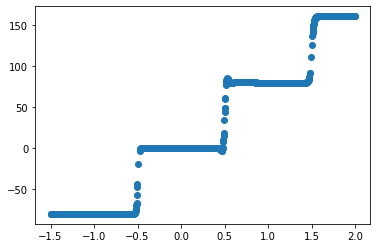

In [40]:
lossesMomentum1 = nn.losses
y_pred = nn.predict(X_test)
plt.scatter(X_test, y_pred)
plt.show()

In [41]:
mean_squared_error(y_pred, Y_test)

14.961715377153341

## RMSProp

In [29]:
nn = MLP(1,[40,1],["sigmoid","linear"],["uniform","uniform","uniform"])
nn.compile(loss = "MSE",optimizer = "RMSProp", lr = 0.1)

In [30]:
nn.fit(X_train, Y_train, epochs = 1000, beta=0.9)

Epoch 1/1000 - loss: 6656.569454752088
Epoch 2/1000 - loss: 6069.654755720129
Epoch 3/1000 - loss: 5568.703695757537
Epoch 4/1000 - loss: 5099.198597330873
Epoch 5/1000 - loss: 4684.2591343007025
Epoch 6/1000 - loss: 4329.590637243553
Epoch 7/1000 - loss: 4029.6781146666294
Epoch 8/1000 - loss: 3775.9349906085117
Epoch 9/1000 - loss: 3560.1468761568935
Epoch 10/1000 - loss: 3375.4262921676145
Epoch 11/1000 - loss: 3216.252758987355
Epoch 12/1000 - loss: 3078.257603273192
Epoch 13/1000 - loss: 2957.9805892304494
Epoch 14/1000 - loss: 2852.662114898174
Epoch 15/1000 - loss: 2760.08045540793
Epoch 16/1000 - loss: 2678.428174452618
Epoch 17/1000 - loss: 2606.219146480892
Epoch 18/1000 - loss: 2542.218588587045
Epoch 19/1000 - loss: 2485.390160588663
Epoch 20/1000 - loss: 2434.8557012638926
Epoch 21/1000 - loss: 2389.864350154437
Epoch 22/1000 - loss: 2349.7686792923105
Epoch 23/1000 - loss: 2314.0060933875957
Epoch 24/1000 - loss: 2282.0842135756598
Epoch 25/1000 - loss: 2253.5692884944833

Epoch 201/1000 - loss: 1260.7883876415594
Epoch 202/1000 - loss: 1257.4570956252226
Epoch 203/1000 - loss: 1253.4109885979674
Epoch 204/1000 - loss: 1250.1380588041907
Epoch 205/1000 - loss: 1246.1453258276392
Epoch 206/1000 - loss: 1242.9076693278312
Epoch 207/1000 - loss: 1238.9468664103078
Epoch 208/1000 - loss: 1235.7310471360527
Epoch 209/1000 - loss: 1231.796687101971
Epoch 210/1000 - loss: 1228.600391771045
Epoch 211/1000 - loss: 1224.6923193141747
Epoch 212/1000 - loss: 1221.5154415800587
Epoch 213/1000 - loss: 1217.6339556943599
Epoch 214/1000 - loss: 1214.476492542355
Epoch 215/1000 - loss: 1210.621141698622
Epoch 216/1000 - loss: 1207.4823966776573
Epoch 217/1000 - loss: 1203.6517767324324
Epoch 218/1000 - loss: 1200.5302676240287
Epoch 219/1000 - loss: 1196.722555087944
Epoch 220/1000 - loss: 1193.6165068795783
Epoch 221/1000 - loss: 1189.8302082416285
Epoch 222/1000 - loss: 1186.738175579641
Epoch 223/1000 - loss: 1182.972528701216
Epoch 224/1000 - loss: 1179.8936842794997

Epoch 400/1000 - loss: 631.7701948029429
Epoch 401/1000 - loss: 629.1751146737752
Epoch 402/1000 - loss: 626.8322266478027
Epoch 403/1000 - loss: 624.2509852328683
Epoch 404/1000 - loss: 621.9205959171248
Epoch 405/1000 - loss: 619.3531558975943
Epoch 406/1000 - loss: 617.0352311035035
Epoch 407/1000 - loss: 614.4815553796307
Epoch 408/1000 - loss: 612.1760484418455
Epoch 409/1000 - loss: 609.6360796913596
Epoch 410/1000 - loss: 607.3429170240228
Epoch 411/1000 - loss: 604.8165563246049
Epoch 412/1000 - loss: 602.5356237401215
Epoch 413/1000 - loss: 600.0227017017638
Epoch 414/1000 - loss: 597.7538065507392
Epoch 415/1000 - loss: 595.2539872530131
Epoch 416/1000 - loss: 592.9966737118216
Epoch 417/1000 - loss: 590.5090198524796
Epoch 418/1000 - loss: 588.2616431960073
Epoch 419/1000 - loss: 585.7825208326889
Epoch 420/1000 - loss: 583.5373465647682
Epoch 421/1000 - loss: 581.0503690424831
Epoch 422/1000 - loss: 578.7735312632537
Epoch 423/1000 - loss: 576.2118348323028
Epoch 424/1000 -

Epoch 598/1000 - loss: 136.5365390443582
Epoch 599/1000 - loss: 136.33821213916988
Epoch 600/1000 - loss: 136.1830429438558
Epoch 601/1000 - loss: 135.9881850129173
Epoch 602/1000 - loss: 135.83176367622647
Epoch 603/1000 - loss: 135.6404347906379
Epoch 604/1000 - loss: 135.48324842088482
Epoch 605/1000 - loss: 135.29560145994466
Epoch 606/1000 - loss: 135.13817536950742
Epoch 607/1000 - loss: 134.9543974891091
Epoch 608/1000 - loss: 134.79723318543705
Epoch 609/1000 - loss: 134.61737830768305
Epoch 610/1000 - loss: 134.46073957933297
Epoch 611/1000 - loss: 134.2845406925164
Epoch 612/1000 - loss: 134.12825279518574
Epoch 613/1000 - loss: 133.95514795123694
Epoch 614/1000 - loss: 133.79870445325128
Epoch 615/1000 - loss: 133.6281674694724
Epoch 616/1000 - loss: 133.4711136140139
Epoch 617/1000 - loss: 133.30301919197552
Epoch 618/1000 - loss: 133.14522177593406
Epoch 619/1000 - loss: 132.97989353610913
Epoch 620/1000 - loss: 132.82144533262428
Epoch 621/1000 - loss: 132.65935005159568


Epoch 794/1000 - loss: 106.37885230934518
Epoch 795/1000 - loss: 106.22614205964129
Epoch 796/1000 - loss: 106.09811568655465
Epoch 797/1000 - loss: 105.95514328551904
Epoch 798/1000 - loss: 105.8351459540491
Epoch 799/1000 - loss: 105.70056056442543
Epoch 800/1000 - loss: 105.58712779766701
Epoch 801/1000 - loss: 105.45953940215765
Epoch 802/1000 - loss: 105.35155341859746
Epoch 803/1000 - loss: 105.23002007330179
Epoch 804/1000 - loss: 105.12686151780258
Epoch 805/1000 - loss: 105.01080174427499
Epoch 806/1000 - loss: 104.9120555670802
Epoch 807/1000 - loss: 104.80089174496774
Epoch 808/1000 - loss: 104.70599587009258
Epoch 809/1000 - loss: 104.598919805162
Epoch 810/1000 - loss: 104.50706754626823
Epoch 811/1000 - loss: 104.4031106545906
Epoch 812/1000 - loss: 104.31344173912538
Epoch 813/1000 - loss: 104.21174819862091
Epoch 814/1000 - loss: 104.12362940360684
Epoch 815/1000 - loss: 104.023687043176
Epoch 816/1000 - loss: 103.93684712791857
Epoch 817/1000 - loss: 103.83850070815191

Epoch 993/1000 - loss: 91.69485001652865
Epoch 994/1000 - loss: 91.62739056513738
Epoch 995/1000 - loss: 91.58637565206601
Epoch 996/1000 - loss: 91.51898872012339
Epoch 997/1000 - loss: 91.47839514682875
Epoch 998/1000 - loss: 91.41107981558886
Epoch 999/1000 - loss: 91.37090458447852
Epoch 1000/1000 - loss: 91.30365994056015


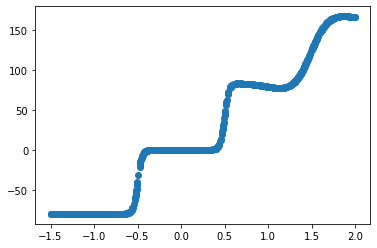

In [31]:
lossesRMSProp1 = nn.losses
y_pred = nn.predict(X_test)
plt.scatter(X_test, y_pred)
plt.show()

In [33]:
mean_squared_error(y_pred, Y_test)

91.1623335478453

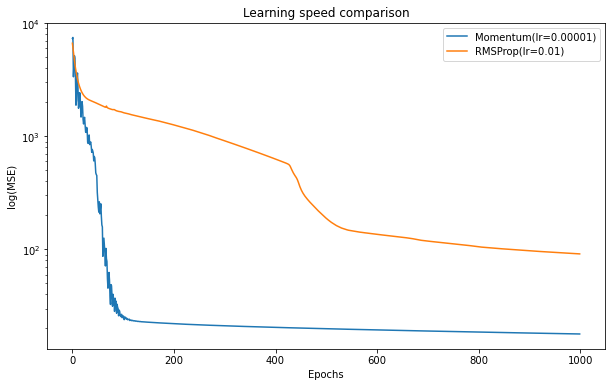

In [42]:
plt.figure(figsize=(10,6))
plt.plot(lossesMomentum1,label="Momentum(lr=0.00001)")
plt.plot(lossesRMSProp1,label="RMSProp(lr=0.01)")
plt.title('Learning speed comparison')
plt.xlabel('Epochs')
plt.ylabel('log(MSE)')
plt.yscale("log")
plt.legend()
plt.show()

# multimodal-large (MSE: 9)

## Momentum

In [14]:
train_df = pd.read_csv("data/multimodal-large-training.csv",index_col=0).reset_index()
test_df = pd.read_csv("data/multimodal-large-test.csv",index_col=0).reset_index()

In [146]:
X_train = np.reshape(train_df["x"].values,(len(train_df),1))
Y_train = np.reshape(train_df["y"].values,(len(train_df),1))

In [147]:
X_test = np.reshape(test_df["x"].values,(len(test_df),1))
Y_test = np.reshape(test_df["y"].values,(len(test_df),1))

In [148]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scalerx = MinMaxScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [149]:
nn = MLP(1,[100,1],["sigmoid","linear"],["uniform","uniform","uniform"])
nn.compile(loss = "MSE",optimizer = "Momentum", lr = 0.000003)

In [150]:
nn.fit(X_train_std, Y_train, epochs = 1000, l=0.9)

Epoch 1/1000 - loss: 6994370.304667157
Epoch 2/1000 - loss: 18933556.80591973
Epoch 3/1000 - loss: 17618.58719302997
Epoch 4/1000 - loss: 824869.0835248346
Epoch 5/1000 - loss: 540828.9023802093
Epoch 6/1000 - loss: 242728.01454839582
Epoch 7/1000 - loss: 110972.4925224756
Epoch 8/1000 - loss: 51168.19125733534
Epoch 9/1000 - loss: 20924.20023151075
Epoch 10/1000 - loss: 5858.094702400622
Epoch 11/1000 - loss: 391.39982845200535
Epoch 12/1000 - loss: 1241.9174619507419
Epoch 13/1000 - loss: 5634.48151399567
Epoch 14/1000 - loss: 11077.708089639187
Epoch 15/1000 - loss: 15586.163274031356
Epoch 16/1000 - loss: 17917.073048251477
Epoch 17/1000 - loss: 17659.402628183423
Epoch 18/1000 - loss: 15143.457694465556
Epoch 19/1000 - loss: 11210.031542333745
Epoch 20/1000 - loss: 6911.748864654272
Epoch 21/1000 - loss: 3224.4962876428845
Epoch 22/1000 - loss: 831.3272797639612
Epoch 23/1000 - loss: 13.726506531064189
Epoch 24/1000 - loss: 654.6010153984579
Epoch 25/1000 - loss: 2331.479203009553

KeyboardInterrupt: 

In [ ]:
lossesMomentum = nn.losses
y_pred = nn.predict(X_test_std)
plt.scatter(X_test, y_pred)
plt.show()

In [ ]:
MSE(y_pred, Y_test)

## RMSProp

In [52]:
nn = MLP(1,[100,1],["sigmoid","linear"],["uniform","uniform","uniform"])
nn.compile(loss = "MSE",optimizer = "RMSProp", lr = 0.2)

In [53]:
nn.fit(X_train_std, Y_train, epochs = 1000, beta=0.9)

Epoch 1/1000 - loss: 5191.75713956697
Epoch 2/1000 - loss: 5751.973868724266
Epoch 3/1000 - loss: 4689.306660600849
Epoch 4/1000 - loss: 4498.288121581435
Epoch 5/1000 - loss: 4319.413185637076
Epoch 6/1000 - loss: 4151.499931424468
Epoch 7/1000 - loss: 3998.1039598929406
Epoch 8/1000 - loss: 3859.4813791631063
Epoch 9/1000 - loss: 3733.3861265766323
Epoch 10/1000 - loss: 3619.2040099566534
Epoch 11/1000 - loss: 3518.46776761999
Epoch 12/1000 - loss: 3430.1408510241395
Epoch 13/1000 - loss: 3348.8173000782053
Epoch 14/1000 - loss: 3269.981433051155
Epoch 15/1000 - loss: 3193.374110335432
Epoch 16/1000 - loss: 3120.2310476641705
Epoch 17/1000 - loss: 3051.959759053324
Epoch 18/1000 - loss: 2989.053750070794
Epoch 19/1000 - loss: 2931.2230074741938
Epoch 20/1000 - loss: 2877.7779582347216
Epoch 21/1000 - loss: 2827.8360029674923
Epoch 22/1000 - loss: 2780.596480601024
Epoch 23/1000 - loss: 2735.42811096817
Epoch 24/1000 - loss: 2691.6835024720276
Epoch 25/1000 - loss: 2648.4671763772767


KeyboardInterrupt: 

In [ ]:
lossesRMSProp = nn.losses
y_pred = nn.predict(X_test)
plt.scatter(X_test, y_pred)
plt.show()

In [ ]:
MSE(y_pred, Y_test)

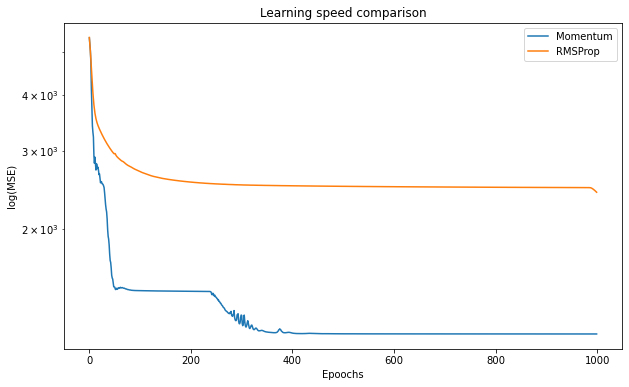

In [680]:
plt.figure(figsize=(10,6))
plt.plot(lossesMomentum,label="Momentum")
plt.plot(lossesRMSProp,label="RMSProp")
plt.title('Learning speed comparison')
plt.xlabel('Epoochs')
plt.ylabel('log(MSE)')
plt.yscale("log")
plt.legend()
plt.show()